## Installs

## Imports

In [227]:
import sys
import os
IN_JUPYTER = False
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB or IN_JUPYTER:
    # Run just in colab
    !git clone https://github.com/ntasfi/PyGame-Learning-Environment
    !pip install gym_ple --index-url https://pypi.org/simple/
    !pip install -e ./PyGame-Learning-Environment --index-url https://pypi.org/simple/
    !pip install pyvirtualdisplay --index-url https://pypi.org/simple/
    !pip install imageio[ffmpeg] --index-url https://pypi.org/simple/
    !sudo apt-get install -y xvfb ffmpeg freeglut3-dev

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ple
    Found existing installation: ple 0.0.1
    Uninstalling ple-0.0.1:
      Successfully uninstalled ple-0.0.1
  Running setup.py develop for ple
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [228]:
if IN_COLAB:
    game_path = '/content'
    from google.colab import files
elif IN_JUPYTER:
    game_path = '/home/avner/projects/reinforcment-midterm'
else:
    game_path = '/Users/scohen6/projects/idc_msc/reinforcment-learning/reinforcment-midterm'

sys.path.append(os.path.join(game_path, 'PyGame-Learning-Environment'))
from ple.games.flappybird import FlappyBird
from ple import PLE
from gym import spaces
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import numpy as np
import gym
import os
import random
import pyvirtualdisplay
import base64
import warnings
import imageio
from abc import ABC, abstractmethod
warnings.filterwarnings("ignore")


In [229]:
import random
import json
from dataclasses import dataclass, field
from typing import Type
from enum import Enum
from collections import namedtuple
import itertools
import numpy as np

## Utility function to display episode

In [230]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [231]:
# to disable the python game window popup
os.environ["SDL_VIDEODRIVER"] = "dummy"

OBSERVATION_MAP = {0: 'player_y',
                   1: "player_vel",
                   2: "next_pipe_dist_to_player",
                   3: "next_pipe_top_y",
                   4: "next_pipe_bottom_y",
                   5: "next_next_pipe_dist_to_player",
                   6: "next_next_pipe_top_y",
                   7: "next_next_pipe_bottom_y",
}

class Game(gym.Env):
    def __init__(self, display_screen=False,
                 force_fps=True,
                 custom_obs=False,
                 pipe_gap=80,
                 custome_observation_map={},
                 preprocess=lambda x: x,
                 reward_shaping=lambda x, y, z: x):

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        game = FlappyBird(pipe_gap=pipe_gap)  # define and initiate the environment
        self.env = PLE(game, fps=30, display_screen=display_screen,
                       force_fps=force_fps)
        self.env.init()
        # list of actions in the environment
        self.actions = self.env.getActionSet()
        # length of actions
        self.action_space = spaces.Discrete(len(self.actions))
        self.custom_obs = custom_obs
        self._observation_map = custome_observation_map if custom_obs else OBSERVATION_MAP
        self.preprocess = preprocess
        self.reward_shaping = reward_shaping
        self.score = 0

    @property
    def observation_space(self):
        return spaces.Box(low=0, high=512, shape=(len(self._observation_map),), dtype=int)

    def _get_rgb(self):
        return self.env.getScreenRGB().transpose(1, 0, 2)

    @property
    def observation_map(self):
        return self._observation_map

    def step(self, action):
        """Take the action chosen and update the reward"""
        reward = self.env.act(self.actions[action])
        if reward < 0:
          reward = -1

        if reward > 0:
          self.score += 1
        state = self.env.getGameState()
        terminal = self.env.game_over()
        reward = self.reward_shaping(reward, terminal, env)
        info = {'score':self.score}
        return self.preprocess(np.array(list(state.values())).astype(int)), reward, terminal, info

    def getGameState(self):
        '''
        PLEenv return gamestate as a dictionary. Returns a modified form
        of the gamestate only with the required information to define the state
        '''
        state = self.env.getGameState()
        h_dist = state['next_pipe_dist_to_player']
        v_dist = state['next_pipe_bottom_y'] - state['player_y']
        vel = state['player_vel']

        return ' '.join([str(vel), str(h_dist), str(v_dist)])

    def reset(self):
        """Resets the game to start a new game"""
        self.env.reset_game()
        state = self.env.getGameState()
        self.score = 0
        return self.preprocess(np.array(list(state.values())).astype(int))

    def render(self, mode='human'):
        """Render the game"""
        return self._get_rgb()

    def seed(self, seed):
        rng = np.random.RandomState(seed)
        self.env.rng = rng
        self.env.game.rng = self.env.rng

        self.env.init()

In [232]:
env = Game(custom_obs=False)

In [233]:
def preprocess(obs):

  def extract_features(obs):
    # Basic feature extraction
    gap_mid_point = (obs[3] + obs[4]) / 2
    return {"gap_mid_point": gap_mid_point,
            "above_middle": gap_mid_point - obs[0],
            }

  # Extract features
  features = extract_features(obs)
  processed_obs = int(bool(features["above_middle"] > -6))

  return processed_obs

In [234]:
def preprocess_2(obs):

    processed_obs = {}

    vel = obs[1]
    x0 = obs[2]
    x1 = obs[5]
    y0 = int((int(obs[3]) + int(obs[4])) / 2) - obs[0]
    #y1 = int((int(obs[6]) + int(obs[7])) / 2) - obs[0]
    if 0 <= x1 < 50 and x0 < x1:
        y1 = int((int(obs[6]) + int(obs[7])) / 2) - obs[0]
    else:
        y1 = 0

    #processed_obs["x0"] = int(bool(x0 < 45))
    if x0 >= 45 and x0 < 65:
        processed_obs["x0"] = 0 # Tried to set to 2, no success
    elif x0 < 45:
        processed_obs["x0"] = 1
    else:
        processed_obs["x0"] = 0

    if y0 > -8 and y0 <= -4:
        processed_obs["y0"] = 0 # Tried to set to 2, no success
    elif y0 > -4:
        processed_obs["y0"] = 1
    else:
        processed_obs["y0"] = 0

    #processed_obs["y0"] = int(bool(y0 > -4))

    processed_obs["vel"] = int(bool(vel >= 0))

    if x1 < 75 and x1 >= 60 and x0 < x1:
        processed_obs["x1"] = 0  # Tried to set to 2, no success
    elif x1 < 60 and x0 < x1:
       processed_obs["x1"] = 1
    else:
       processed_obs["x1"] = 0
    #processed_obs["x1"] = int(bool(x1 < 60) and x0 < x1)

    if y1 > -12 and y1 <= -8 and y1 < y0:
        processed_obs["y1"] = 0  # Tried to set to 2, no success
    elif y1 > -8 and y1 < y0:
        processed_obs["y1"] = 1
    else:
        processed_obs["y1"] = 0
    #processed_obs["y1"] = int(bool(y1 > -8 and y1 < y0))

    return str(tuple(processed_obs.values()))


In [235]:
def preprocess_3(obs):

    # Extract features
    self_y = obs[0]
    vel = obs[1]

    # FEATURE 1
    # y diff to next pipe
    gap_mid_point = (obs[3] + obs[4]) / 2
    above_middle = gap_mid_point - self_y

    # y0 is the vertical difference to the middle of next gap
    UPPER_GAP = 23 # 5
    LOWER_GAP = -4
    if above_middle > UPPER_GAP:  # High, above middle. Important since we want to start gaining height if the next_next gap is very high
        y0 = 0
    elif above_middle > LOWER_GAP:  # Medium, close to middle. If next_next gap is very high - this is not enough.
        y0 = 1
    else:  # Below the middle of the gap
        y0 = 2

    # FEATURE 2
    # Movement direction
    direction = int(bool(vel >=0))

    # FEATURE 3
    next_next_gap_mid_point = (obs[6] + obs[7]) / 2
    is_next_next_higher = int(bool(next_next_gap_mid_point > gap_mid_point))

    # x0 tells the bird if it's near the end of the the current gap.
    # NEAR_END_OF_CURR_GAP = 10
    # x0 = int(bool(obs[2] < NEAR_END_OF_CURR_GAP))

    # # Define feature bins
    # y1_bins = np.linspace(-20, 10, num=4)
    # y2_bins = np.linspace(-150, 150, num=4)

    # # Bin feature values
    # y1_bin = np.digitize(above_middle, y1_bins)
    # y2_bin = np.digitize(above_next_middle, y2_bins)

    return str((y0, direction, is_next_next_higher))  # a vector in the cartesian product {0, 1, 2} X {0, 1} X {0, 1}

    # extracted_features = (int(y1_bin), int(y2_bin))
    # return str(extracted_features)

In [236]:
def reward_shaping(reward, terminal, env):
  # Added a third argument, `env`, to the function supplied in the exercise

  SURVIVAL_REWARD = 1
  TERMINAL_PUNISHMENT = 50  # This sounds so evil

  # Reward surviving another stp
  reward += SURVIVAL_REWARD

  # Other optional rewards/punishments
    # Reward moving towards the middle of the gap
    # Punish being beyond the bounderies of the upcoming gap
    # Small punishment for not being in the gap of next-next gap

  # Punish terminal states (user lost)
  if terminal:
    reward -= TERMINAL_PUNISHMENT

  return reward

In [237]:
from abc import ABC, abstractmethod

class OnPolicyAgent(ABC):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon=1, epsilon_decay=0.99, min_epsilon=0.1):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self._set_random_policy()

    def _set_random_policy(self):
        # Initialize a random policy. Consider other formats for efficiency, e.g. ndarray or pandas df
        self.policy = {
            state: [
                0 #round(random.random(), 4)
                for action in self.action_space
            ]
            for state in self.observation_space
        }
        print(f"Initialized a random policy: {json.dumps(str(self.policy), indent=4)}")  # Debugging

    @abstractmethod
    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        pass

    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
        - file_path: Path to the file from which the policy should be loaded
        """
        print(f"Loading policy from {file_path}")
        with open(file_path, 'r') as f:
            policy = json.load(f)

        typeof_dict = type(list(policy.values())[0]).__name__
        if typeof_dict == "dict":
            self.policy = {
                int(state_key): {
                    int(action): value
                    for action, value in actions_dict.items()
                }
                for state_key, actions_dict in policy.items()
            }
        else:
            self.policy = {
                state_key: actions_list
                for state_key, actions_list in policy.items()
            }

        print(f"Loaded policy: {json.dumps(self.policy, indent=4)}")

    def run_policy(self, env, num_episodes, video_dir):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
        - env: The environment in which to run the policy

        Returns:
        - total_reward: Total reward accumulated in the episode
        """

        # Single episode, like method docstring states
        max_steps = 10_000
        video_filenames = []
        metrics = {}
        metrics['score_by_episodes'] = []
        metrics['steps_by_episodes'] = []
        metrics["reward_by_steps"] = []
        metrics["action_by_steps"] = []
        # This should be extracted to a helper function and used in training also
        # Need to add a flag for 'train' to allow updating policy
        for episode in range(num_episodes):  # NOTE: according to docstring this shouldn't be a loop - rather a single episode
            # Resetting environment and getting first observation
            print(f"Starting episode #{episode}")
            metrics["reward_by_steps"].append([])
            metrics["action_by_steps"].append([])
            obs = env.reset()  # obs is now the initial state
            done = False
            total_reward = 0
            total_actions = 0

            os.makedirs(video_dir, exist_ok=True)
            video_filename = os.path.join(video_dir ,f'{type(self).__name__.lower()}_{episode+1}_eval.mp4')
            video_filenames.append(video_filename)
            with imageio.get_writer(video_filename, fps=24) as video:
                for step in range(max_steps):

                    # print(f"obs is {obs}")

                    # Select action
                    selected_action = self.select_action(obs)

                    # Perform action, get reward and new state
                    new_obs, reward, done, info = env.step(selected_action)

                    # Update the environment after last step
                    total_reward += reward
                    if (selected_action == 0):
                      total_actions += 1
                    else:
                      total_actions -= 1
                    obs = new_obs

                    # Update video
                    re = env.render()
                    video.append_data(re)

                    metrics["reward_by_steps"][episode].append([step, total_reward])
                    metrics["action_by_steps"][episode].append([step, total_actions])

                    # Terminate training loop when encountring a terminal state
                    if done:
                      score = info['score']
                      metrics['steps_by_episodes'].append([episode, step])
                      metrics['score_by_episodes'].append([episode, info['score']])
                      print("Encountered a terminal state")
                      print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
                      break

        return video_filenames, metrics

In [238]:
class TrivialPolicy(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        super().__init__(action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon)
        print('Initializing with action space:', action_space)
        print('Initializing with observation space:', observation_space)

    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        # NOTE: 0 is going UP and 1 is going DOWN, unlike instructions.

        explore = random.random() < self.epsilon
        if explore:
          print(f"Going by the book is boring. Let's explore")
          random_action = random.randint(0, len(self.action_space) - 1)
          return random_action

        state_actions = self.policy[observation]
        best_action = state_actions.index(max(state_actions))
        return best_action

In [239]:
class QLearningPolicy(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        # Note: hyperparameters aren't being used yet
        super().__init__(action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon)
        print('Initializing with action space:', action_space)
        print('Initializing with observation space of size:', len(observation_space))

    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        # NOTE: 0 is going UP and 1 is going DOWN, unlike instructions.
        explore = random.random() < self.epsilon
        if explore:
          # print(f"Going by the book is boring. Let's explore")
          random_action = random.randint(0, len(self.action_space) - 1)
          return random_action
        return bool(self.policy[observation][0] < self.policy[observation][1])

In [240]:
class SarsaPolicy(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        # Note: hyperparameters aren't being used yet
        super().__init__(action_space, observation_space, gamma, learning_rate, epsilon, epsilon_decay, min_epsilon)
        print('Initializing with action space:', action_space)
        print('Initializing with observation space of size', len(observation_space))

    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        # NOTE: 0 is going UP and 1 is going DOWN, unlike instructions.
        explore = random.random() < self.epsilon
        if explore:
          print(f"Going by the book is boring. Let's explore")
          random_action = random.randint(0, 1)
          return random_action
        return bool(self.policy[observation][0] < self.policy[observation][1])

### Experiments

In [241]:
class Hyperparameters(Enum):
    GAMMA = 'gamma'
    LEARNING_RATE = 'learning_rate'
    EPSILON = 'epsilon'
    EPSILON_DECAY = 'epsilon_decay'
    MIN_EPSILON = 'min_epsilon'

In [242]:
class Graphs:
    def plot_score_by_episodes(self, array_to_plot, model_name, additional_info=None):
      x, y = np.array(array_to_plot).T
      mean_y = [np.mean(y[:i+1]) for i in range(len(y))]
      max_y = [np.max(y[:i+1]) for i in range(len(y))]
      plt.scatter(x, y)
      plt.plot(x, mean_y)
      plt.plot(x, max_y)
      plt.title(f"Score by episodes - {model_name} {additional_info}" if additional_info else f"Score by episodes - {model_name}")
      plt.xlabel("Episodes")
      plt.ylabel("Score")
      plt.legend(['scores','mean score', 'max score'], loc='upper left')
      plt.show()

    def plot_step_by_episodes(self, array_to_plot, model_name, additional_info=None):
      x, y = np.array(array_to_plot).T
      mean_y = [np.mean(y[:i+1]) for i in range(len(y))]
      max_y = [np.max(y[:i+1]) for i in range(len(y))]
      plt.scatter(x, y)
      plt.plot(x, mean_y)
      plt.plot(x, max_y)
      plt.title(f"Step by episodes - {model_name} {additional_info}" if additional_info else f"Step by episodes - {model_name}")
      plt.xlabel("Episodes")
      plt.ylabel("Steps")
      plt.legend(['steps','mean steps', 'max steps'], loc='upper left')
      plt.show()

    def plot_reward_by_steps(self, array_to_plot, model_name, additional_info=None):
      x, y = np.array(array_to_plot).T
      plt.scatter(x, y)
      plt.title(f"Total reward by step - {model_name} {additional_info}" if additional_info else f"Total reward by step - {model_name}")
      plt.xlabel("Steps")
      plt.ylabel("Reward")
      plt.legend(['total reward'], loc='upper left')
      plt.show()

    def plot_action_by_steps(self, array_to_plot, model_name, additional_info=None):
      x, y = np.array(array_to_plot).T
      plt.plot(x, y)
      plt.title(f"Action by step - {model_name} {additional_info}" if additional_info else f"Action by step - {model_name}")
      plt.xlabel("Steps")
      plt.ylabel("Actions")
      plt.legend(['action'], loc='upper left')
      plt.show()


In [243]:
@dataclass
class Evaluation:
    eval_count: int = field(default=0, init=False, repr=False)
    environment: Game
    agent_class: Type[OnPolicyAgent]
    hyperparameters: dict
    action_space: list[int]
    observation_space: list[int]
    n_episodes_eval: int
    log_every: int
    policy_file: str
    max_steps: int
    eval_metrics: dict = field(init=False)
    eval_videos_path: list[str] = field(init=False)
    policy: OnPolicyAgent = field(init=False)

    def __post_init__(self):
        # self.environment.seed(42)
        self.environment.reset()
        self.policy = self.agent_class(
            self.action_space,
            self.observation_space,
            0,
            0,
            0,
            0,
            0
        )

        self.experiment_path = game_path
        self.eval_count += 1

    def run_evaluation(self):
        print(f"Running evaluation {self.eval_count - 1} for {self.n_episodes_eval} episodes")
        self.policy.load_policy(os.path.join(self.experiment_path, self.policy_file))
        self.eval_videos_path, self.eval_metrics = self.policy.run_policy(
            self.environment,
            self.n_episodes_eval,
            self.experiment_path
        )

    def plot_eval_metrics(self, plot_score=True, plot_steps=True, plot_reward=True, plot_actions=True, additional_info=None):
      graphs = Graphs()
      if plot_score:
        graphs.plot_score_by_episodes(self.eval_metrics["score_by_episodes"], type(self.policy).__name__, additional_info)

      if plot_steps:
        graphs.plot_step_by_episodes(self.eval_metrics["steps_by_episodes"], type(self.policy).__name__, additional_info)

      if plot_reward:
        for i in range(len(self.eval_metrics["reward_by_steps"])):
          graphs.plot_reward_by_steps(self.eval_metrics["reward_by_steps"][i], type(self.policy).__name__, f"{additional_info} - episode {i}")

      if plot_actions:
        for i in range(len(self.eval_metrics["action_by_steps"])):
          graphs.plot_action_by_steps(self.eval_metrics["action_by_steps"][i], type(self.policy).__name__, f"{additional_info} - episode {i}")

    def get_eval_mean_score(self):
      x, y = np.array(self.eval_metrics["score_by_episodes"]).T
      return np.mean(y)

    def get_eval_max_score(self):
      x, y = np.array(self.eval_metrics["score_by_episodes"]).T
      return np.max(y)

    def get_eval_max_episode(self):
      x, y = np.array(self.eval_metrics["score_by_episodes"]).T
      return np.argmax(y)

    def get_eval_scores(self):
      x, y = np.array(self.eval_metrics["score_by_episodes"]).T
      return y

In [244]:
all_evaluations = {}

#### Heuristic agent experiments

In [245]:
heuristic_experiment_easy = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess, pipe_gap=80, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = TrivialPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0,
        Hyperparameters.EPSILON_DECAY: 0,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [0, 1],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 1000,
    policy_file = 'heuristic_experiment_easy.json'
)

Initialized a random policy: "{0: [0, 0], 1: [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space: [0, 1]


In [246]:
all_evaluations['heuristic_experiment_easy'] = heuristic_experiment_easy

In [247]:
heuristic_experiment_hard = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess, pipe_gap=80, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = TrivialPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0,
        Hyperparameters.EPSILON_DECAY: 0,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [0, 1],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 1000,
    policy_file = 'heuristic_experiment_hard.json'
)

Initialized a random policy: "{0: [0, 0], 1: [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space: [0, 1]


In [248]:
all_evaluations['heuristic_experiment_hard'] = heuristic_experiment_hard

### Q Learning agent experiments

In [249]:
q_experiment_easy = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess, pipe_gap=80, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = QLearningPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0,
        Hyperparameters.EPSILON_DECAY: 0,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [0, 1],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 1000,
    policy_file = 'q_experiment_easy.json'
)

Initialized a random policy: "{0: [0, 0], 1: [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size: 2


In [250]:
all_evaluations['q_experiment_easy'] = q_experiment_easy

In [251]:
q_experiment_hard = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_2, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = QLearningPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in itertools.product([0, 1], repeat=5)],  # All binary tuples of length 5
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'q_experiment_hard.json'
)

Initialized a random policy: "{'(0, 0, 0, 0, 0)': [0, 0], '(0, 0, 0, 0, 1)': [0, 0], '(0, 0, 0, 1, 0)': [0, 0], '(0, 0, 0, 1, 1)': [0, 0], '(0, 0, 1, 0, 0)': [0, 0], '(0, 0, 1, 0, 1)': [0, 0], '(0, 0, 1, 1, 0)': [0, 0], '(0, 0, 1, 1, 1)': [0, 0], '(0, 1, 0, 0, 0)': [0, 0], '(0, 1, 0, 0, 1)': [0, 0], '(0, 1, 0, 1, 0)': [0, 0], '(0, 1, 0, 1, 1)': [0, 0], '(0, 1, 1, 0, 0)': [0, 0], '(0, 1, 1, 0, 1)': [0, 0], '(0, 1, 1, 1, 0)': [0, 0], '(0, 1, 1, 1, 1)': [0, 0], '(1, 0, 0, 0, 0)': [0, 0], '(1, 0, 0, 0, 1)': [0, 0], '(1, 0, 0, 1, 0)': [0, 0], '(1, 0, 0, 1, 1)': [0, 0], '(1, 0, 1, 0, 0)': [0, 0], '(1, 0, 1, 0, 1)': [0, 0], '(1, 0, 1, 1, 0)': [0, 0], '(1, 0, 1, 1, 1)': [0, 0], '(1, 1, 0, 0, 0)': [0, 0], '(1, 1, 0, 0, 1)': [0, 0], '(1, 1, 0, 1, 0)': [0, 0], '(1, 1, 0, 1, 1)': [0, 0], '(1, 1, 1, 0, 0)': [0, 0], '(1, 1, 1, 0, 1)': [0, 0], '(1, 1, 1, 1, 0)': [0, 0], '(1, 1, 1, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size: 32


In [252]:
all_evaluations['q_experiment_hard'] = q_experiment_hard

In [253]:
q_experiment_hard2 = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_3, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = QLearningPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in list(itertools.product({0, 1, 2}, {0, 1}, {0, 1}))],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'q_experiment_hard2.json'
)

Initialized a random policy: "{'(0, 0, 0)': [0, 0], '(0, 0, 1)': [0, 0], '(0, 1, 0)': [0, 0], '(0, 1, 1)': [0, 0], '(1, 0, 0)': [0, 0], '(1, 0, 1)': [0, 0], '(1, 1, 0)': [0, 0], '(1, 1, 1)': [0, 0], '(2, 0, 0)': [0, 0], '(2, 0, 1)': [0, 0], '(2, 1, 0)': [0, 0], '(2, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size: 12


In [254]:
all_evaluations['q_experiment_hard2'] = q_experiment_hard2

In [255]:
q_experiment_hard2_hypherparams = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_3, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = QLearningPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.7,
        Hyperparameters.LEARNING_RATE: 0.3,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in list(itertools.product({0, 1, 2}, {0, 1}, {0, 1}))],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'q_experiment_hard2_hypherparams.json'
)

Initialized a random policy: "{'(0, 0, 0)': [0, 0], '(0, 0, 1)': [0, 0], '(0, 1, 0)': [0, 0], '(0, 1, 1)': [0, 0], '(1, 0, 0)': [0, 0], '(1, 0, 1)': [0, 0], '(1, 1, 0)': [0, 0], '(1, 1, 1)': [0, 0], '(2, 0, 0)': [0, 0], '(2, 0, 1)': [0, 0], '(2, 1, 0)': [0, 0], '(2, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size: 12


In [256]:
all_evaluations['q_experiment_hard2_hypherparams'] = q_experiment_hard2_hypherparams

### SARSA agent experiments

In [257]:
sarsa_experiment_easy = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess, pipe_gap=80, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = SarsaPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0,
        Hyperparameters.EPSILON_DECAY: 0,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [0, 1],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 1000,
    policy_file = 'sarsa_experiment_easy.json'
)

Initialized a random policy: "{0: [0, 0], 1: [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size 2


In [258]:
all_evaluations['sarsa_experiment_easy'] = sarsa_experiment_easy

In [259]:
sarsa_experiment_hard = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_2, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = SarsaPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in itertools.product([0, 1], repeat=5)],  # All binary tuples of length 4
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'sarsa_experiment_hard.json'
)

Initialized a random policy: "{'(0, 0, 0, 0, 0)': [0, 0], '(0, 0, 0, 0, 1)': [0, 0], '(0, 0, 0, 1, 0)': [0, 0], '(0, 0, 0, 1, 1)': [0, 0], '(0, 0, 1, 0, 0)': [0, 0], '(0, 0, 1, 0, 1)': [0, 0], '(0, 0, 1, 1, 0)': [0, 0], '(0, 0, 1, 1, 1)': [0, 0], '(0, 1, 0, 0, 0)': [0, 0], '(0, 1, 0, 0, 1)': [0, 0], '(0, 1, 0, 1, 0)': [0, 0], '(0, 1, 0, 1, 1)': [0, 0], '(0, 1, 1, 0, 0)': [0, 0], '(0, 1, 1, 0, 1)': [0, 0], '(0, 1, 1, 1, 0)': [0, 0], '(0, 1, 1, 1, 1)': [0, 0], '(1, 0, 0, 0, 0)': [0, 0], '(1, 0, 0, 0, 1)': [0, 0], '(1, 0, 0, 1, 0)': [0, 0], '(1, 0, 0, 1, 1)': [0, 0], '(1, 0, 1, 0, 0)': [0, 0], '(1, 0, 1, 0, 1)': [0, 0], '(1, 0, 1, 1, 0)': [0, 0], '(1, 0, 1, 1, 1)': [0, 0], '(1, 1, 0, 0, 0)': [0, 0], '(1, 1, 0, 0, 1)': [0, 0], '(1, 1, 0, 1, 0)': [0, 0], '(1, 1, 0, 1, 1)': [0, 0], '(1, 1, 1, 0, 0)': [0, 0], '(1, 1, 1, 0, 1)': [0, 0], '(1, 1, 1, 1, 0)': [0, 0], '(1, 1, 1, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size 32


In [260]:
all_evaluations['sarsa_experiment_hard'] = sarsa_experiment_hard

In [261]:
sarsa_experiment_hard2 = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_3, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = SarsaPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.9,
        Hyperparameters.LEARNING_RATE: 0.1,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in list(itertools.product({0, 1, 2}, {0, 1}, {0, 1}))],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'sarsa_experiment_hard2.json'
)

Initialized a random policy: "{'(0, 0, 0)': [0, 0], '(0, 0, 1)': [0, 0], '(0, 1, 0)': [0, 0], '(0, 1, 1)': [0, 0], '(1, 0, 0)': [0, 0], '(1, 0, 1)': [0, 0], '(1, 1, 0)': [0, 0], '(1, 1, 1)': [0, 0], '(2, 0, 0)': [0, 0], '(2, 0, 1)': [0, 0], '(2, 1, 0)': [0, 0], '(2, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size 12


In [262]:
all_evaluations['sarsa_experiment_hard2'] = sarsa_experiment_hard2

In [263]:
sarsa_experiment_hard2_hypherparams = Evaluation(
    environment = Game(custom_obs=True, preprocess=preprocess_3, pipe_gap=65, reward_shaping=reward_shaping, custome_observation_map=None),
    agent_class = SarsaPolicy,
    hyperparameters = {
        Hyperparameters.GAMMA: 0.7,
        Hyperparameters.LEARNING_RATE: 0.3,
        Hyperparameters.EPSILON: 0.1,
        Hyperparameters.EPSILON_DECAY: 0.9,
        Hyperparameters.MIN_EPSILON: 0
    },
    action_space = [0, 1],
    observation_space = [str(state) for state in list(itertools.product({0, 1, 2}, {0, 1}, {0, 1}))],
    n_episodes_eval = 10,
    log_every = 1000,
    max_steps = 5000,
    policy_file = 'sarsa_experiment_hard2_hypherparams.json'
)

Initialized a random policy: "{'(0, 0, 0)': [0, 0], '(0, 0, 1)': [0, 0], '(0, 1, 0)': [0, 0], '(0, 1, 1)': [0, 0], '(1, 0, 0)': [0, 0], '(1, 0, 1)': [0, 0], '(1, 1, 0)': [0, 0], '(1, 1, 1)': [0, 0], '(2, 0, 0)': [0, 0], '(2, 0, 1)': [0, 0], '(2, 1, 0)': [0, 0], '(2, 1, 1)': [0, 0]}"
Initializing with action space: [0, 1]
Initializing with observation space of size 12


In [264]:
all_evaluations['sarsa_experiment_hard2_hypherparams'] = sarsa_experiment_hard2_hypherparams

## Validation

#### Validation Section

In this section, you will validate your agent’s performance using the best-performing configuration identified in the experimentation phase. This validation step should be less exhaustive than the experimentation section but should provide sufficient evidence of your agent's consistency and stability.

1. **Run Validation Trials**:
   - Using the chosen configuration, run the agent in the environment for **multiple trials** (e.g., 5-10 episodes) to test its reliability.
   - Observe the agent's performance across these trials to confirm whether it consistently achieves or exceeds the target score of 10.

2. **Provide Key Summaries**:
   - **Performance Metrics**: Summarize the agent’s performance with key metrics such as average score, highest score, and variance across trials.
   - **Graphs** (Optional): Include basic graphs showing score progression or any other relevant metric, if they provide additional insight into the agent's stability.

3. **Brief Analysis**:
   - Reflect on the agent's performance in validation. Note any patterns or inconsistencies and provide a short explanation of how these results align (or differ) from your expectations based on the experimentation phase.

*Note*: This validation section should confirm and strengthen the results of your experimentation, focusing on reliability and consistency rather than extensive analysis.

*Note*: Store the agent's policy to files since you asked to provide aditional notbook that loads the agent policy


In [265]:
## Upload a policy file. Before submission we should comment it out
!rm -rf *.json
policy_file = files.upload()

Saving q_experiment_hard2_hypherparams.json to q_experiment_hard2_hypherparams.json


In [266]:
selected_evaluation = None

for eval_name, evaluation in all_evaluations.items():
  if os.path.isfile(evaluation.policy_file):
    print(f"{eval_name} policy file exists")
    selected_evaluation = evaluation

q_experiment_hard2_hypherparams policy file exists


In [267]:
assert selected_evaluation is not None, "No policy file exists in the environment. Please add to /content folder a valid policy file"

In [268]:
selected_evaluation.run_evaluation()

Running evaluation 0 for 10 episodes
Loading policy from /content/q_experiment_hard2_hypherparams.json
Loaded policy: {
    "(0, 0, 0)": [
        3.3283545353738195,
        -12.652773478440714
    ],
    "(0, 0, 1)": [
        2.705145103344109,
        -20.02172829578478
    ],
    "(0, 1, 0)": [
        -13.21814132431522,
        2.435571741130674
    ],
    "(0, 1, 1)": [
        -15.202243391570573,
        3.445173226558903
    ],
    "(1, 0, 0)": [
        3.345050033162628,
        0
    ],
    "(1, 0, 1)": [
        3.381725013644077,
        0
    ],
    "(1, 1, 0)": [
        3.3668792697977086,
        0
    ],
    "(1, 1, 1)": [
        3.530267590757008,
        -1.205867810707832
    ],
    "(2, 0, 0)": [
        3.0849162603647775,
        -12.370341004305116
    ],
    "(2, 0, 1)": [
        -13.300584731329929,
        -15.807702038093561
    ],
    "(2, 1, 0)": [
        3.2325030328257274,
        -12.29284155369127
    ],
    "(2, 1, 1)": [
        1.925273310499

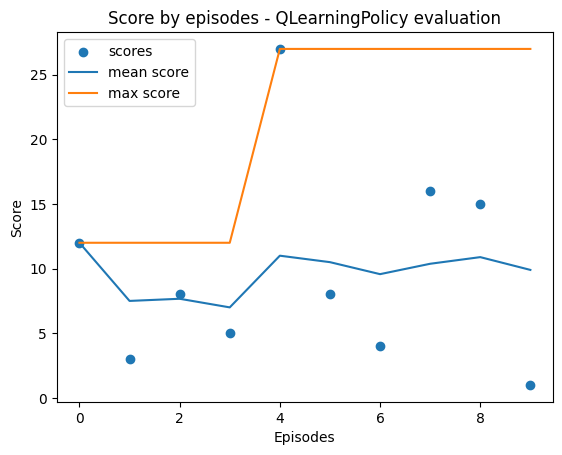

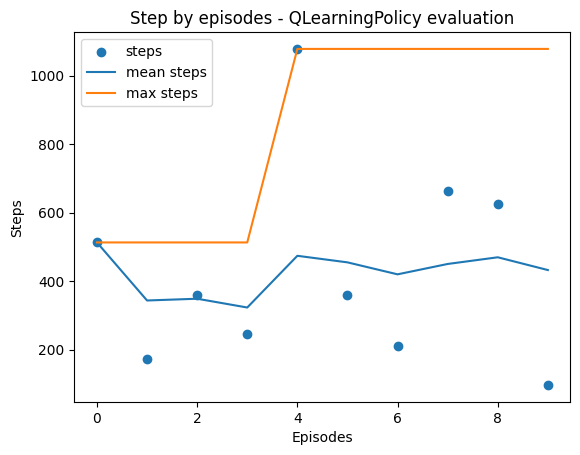

In [269]:
selected_evaluation.plot_eval_metrics(plot_score=True, plot_steps=True, plot_reward=False, plot_actions=False, additional_info="evaluation")

In [270]:
df = pd.DataFrame({'Scores': selected_evaluation.get_eval_scores()})

df

,Scores
0,12
1,3
2,8
3,5
4,27
5,8
6,4
7,16
8,15
9,1


In [271]:
max_score = selected_evaluation.get_eval_max_score()
max_episode = selected_evaluation.get_eval_max_episode()
print(f"Episode number {max_episode} has the highest score of {max_score}. Playing it's video")

Episode number 4 has the highest score of 27. Playing it's video


In [272]:
embed_mp4(selected_evaluation.eval_videos_path[max_episode])